# <center>Graph Analytics</center>

***
In this project, I will create a Graph that is going to describe the reationship between people who tweet and those who retweet by analysing each user as a node and the edges to be the polarity/sentiment of the tweets in the art hashtag.
***

In [79]:
%config Completer.use_jedi = False
%matplotlib inline

import pandas as pd
import networkx as nx
from tweepy import OAuthHandler, API, api
import tweepy
from pprint import pprint
import json as js
import pandas as pd
from textblob import TextBlob
import operator
import matplotlib.pyplot as plt

In [2]:
consumer_key = 
consumer_secret = 
access_token = 
access_secret = 

In [3]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

## SETING UP twitter API client

In [4]:
api = API(auth,  wait_on_rate_limit=True)

## Defining search variables:

In [5]:
search_words ="art" # We are going to analyse the art community
number_posts = 1000

In [14]:
tweets = []
status = []
tweets_Cursor = tweepy.Cursor(api.search, 
                   q=search_words,
                   lang="en",
                   tweet_mode='extended').items(number_posts)

for tweet in tweets_Cursor:
    tweets.append(tweet._json["full_text"])
    status.append(tweet._json)

## Importing the results from an previously saved text file

***
We saved the data into a text file so that you could access the same data that we used for the analysis given 
that they change over time, and the analysis may not be adequate anymore.
***

In [22]:
status = []
tweets = []

path = 'tweets_art.json'
with open( path , 'r', encoding='utf8') as file:
    for line in file:
        status.append(js.loads(line))
        
status = status[0]
tweets = [status[i]["full_text"] for i in range(len(status))]

In [16]:
len(status)

1000

In [20]:
status[0]["full_text"]

'@plentyofalcoves Its actually similar to not needing to thumbnail everything in art, sometimes you just have the vision and know how to execute it without blocking/boarding first ┐(´ー｀)┌'

## Creating pairs

In [23]:
pairs = list()
index = list()

counter = 0
for tweet in status:
    mentions = tweet['entities']['user_mentions']
    if mentions:
        for i in range(len(mentions)):
            pairs.append([tweet['user']['screen_name'], mentions[i]['screen_name']])
            index.append(counter)
    counter +=1

In [24]:
tweets_text = [tweets[i] for i in index]

In [25]:
sentiment_polarity = list()

for tweet in tweets_text:
    statement = TextBlob(tweet)
    sentiment_polarity.append(statement.sentiment.polarity * statement.sentiment.subjectivity)

## Creating the data frame

In [26]:
df = pd.DataFrame.from_records(pairs)
df.columns = ['from', 'to']

df.drop_duplicates(subset=None, keep='first', inplace=False)

df["sentiment"] = sentiment_polarity
df.sort_values(by = 'sentiment')
df.head(11)

,from,to,sentiment
0,GremIsOnline,plentyofalcoves,0.045833
1,wiccan1978,amidstbook,-0.025000
2,teamiwaizumi,sugawarapics,0.048611
3,HardSundae,vexwerewolf,0.000000
4,extremecollect,AustinTByrd,0.000000
5,Mama_Goomba,Mama_Goomba,0.093750
6,robin2jumpstart,MarshallJulius,0.039291
7,robin2jumpstart,Etsy,0.039291
8,LordSnow59,VideoArtGame,0.000000
9,LordSnow59,kageuri,0.000000


## Creating the network

In [27]:
mynetwork = nx.from_pandas_edgelist(df, source = "from", target = "to", edge_attr = 'sentiment', create_using=nx.DiGraph())

In [28]:
print(nx.info(mynetwork))

Name: 
Type: DiGraph
Number of nodes: 1460
Number of edges: 1038
Average in degree:   0.7110
Average out degree:   0.7110


## Analysing the network

### Macro-level analysis

In [29]:
#Density of the network
nx.density(mynetwork)

0.00048729191508539347

The density is very small, this is a sign that the network does not comport many connections between the users (nodes) which is what one would expect in a hashtag page. In fact, one user is not going to reply on every single tweet in the hashtag page, but rather on just one or for the most a tiny amount, and then move on with his day.

In [30]:
nx.average_shortest_path_length(mynetwork)

NetworkXError: Graph is not weakly connected.

Here we see that an error has been rased. It says that the graph is not weakly connected, so there exists two nodes that are not connected, and if we think about it, it is natural not to find a series of tweet creator/tagged between all users. In fact, it is quiet improbable.

In [31]:
#Clustering coefficient:
nx.algorithms.cluster.average_clustering(mynetwork)

0.01761904761904762

### Mirco-level analysis

We chose the purpose for this analysis to be determining the user who has the most important role in the dynamics of the art hashtag and work locally on its node

In [32]:
#HIGHEST DEGREE CENTRALITY
degree_stats = nx.algorithms.centrality.degree_centrality(mynetwork)
degree_centralnode = max(degree_stats.items(), key=operator.itemgetter(1))[0]
degree_centralnode

'AustinTByrd'

In [33]:
#HIGHEST CLOSENESS CENTRALITY
closeness_stats = nx.algorithms.centrality.closeness_centrality(mynetwork)
closeness_centralnode = max(closeness_stats.items(), key=operator.itemgetter(1))[0]
closeness_centralnode

'AustinTByrd'

In [34]:
#HIGHEST BETWEENNESS CENTRALITY
betweenness_stats = nx.algorithms.centrality.betweenness_centrality(mynetwork)
betweenness_centralnode = max(betweenness_stats.items(), key=operator.itemgetter(1))[0]
betweenness_centralnode

'srn_art'

### Let's calculate the other coefficients for each resulting user:

In [38]:
#For AustinTByrd:
degree_coefficient_Austin = degree_stats['AustinTByrd']
closeness_coefficient_Austin = closeness_stats['AustinTByrd']
betweenness_coefficient_Austin = betweenness_stats['AustinTByrd']

In [39]:
#For srn_art:
degree_coefficient_srn = degree_stats['srn_art']
closeness_coefficient_srn = closeness_stats['srn_art']
betweenness_coefficient_srn = betweenness_stats['srn_art']

### Analysing the results:

The first thing we can say in regards to these results are that the user @AustinTByrd is both a degree_based central node and closeness_based central node, which means that he is hugely important in the dynamics of the conversations in the art hashtag. The high degree centrality gives him a high exposure to other users and the high closeness centrality property gives him the power to attach different clusters within the network. So we can safely say that he is the one who's kinda holding the hashtag together.
The user @srn_art has the highest betweenness centrality coefficient which means that she is a user that can easily spread information through the network, at least easier than the other users.

In [40]:
#The coefficient of betweeness of the user @AustinBryd:
betweenness_coefficient_Austin

0.0

@AustinBryd has a null betweenness coefficient which means that despite his multiple connections,they are not intelligent (redundant), and users can easily bypass him for connections. At the same time, even though he has a high closeness value, so are many other users in the grid.

In [41]:
#The dcoefficients of betweeness and degree for the user @srn_art:
degree_coefficient_srn, closeness_coefficient_srn

(0.00411240575736806, 0.0006854009595613434)

This user though has a medium degree and coefficient coefficients,which means that she is very crucial to the maintenance of the flow of information, and does not have a very high number of connections. This creates a risk that: her leaving might means that this information system can very much lack a solid source of new information.

### Drawing the network

In [53]:
layout = nx.spring_layout(mynetwork)

In [64]:
edges,weights = zip(*nx.get_edge_attributes(mynetwork,'sentiment').items())

In [55]:
edges = mynetwork.edges

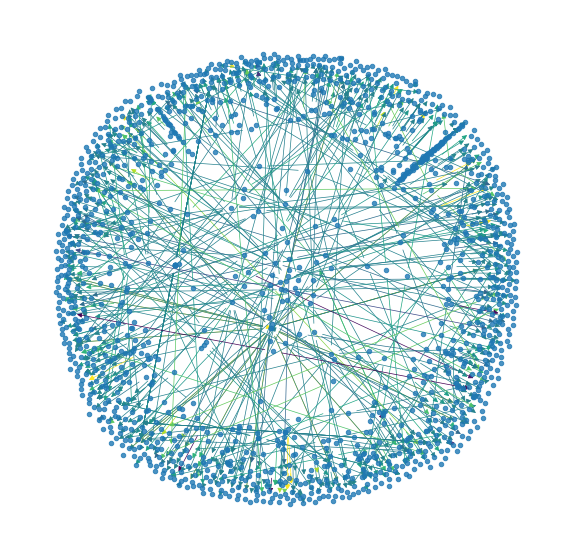

In [69]:
plt.figure(figsize = (10,10))
plt.axis('off')
nx.draw_networkx_nodes(mynetwork, pos = layout, node_size=20, alpha=0.8)
nx.draw_networkx_edges(mynetwork, pos = layout, width = 0.7, edgelist=edges, edge_color=weights, edge_cmap=plt.cm.viridis)
plt.show()

### Saving the network

In [70]:
nx.write_gml(mynetwork, 'Art_Graph.gml')

In [85]:
len(mynetwork)

1460

### Community detection

In [90]:
#Turining the graph into a non directed graph
mynetwork_non = nx.from_pandas_edgelist(df, source = "from", target = "to", edge_attr = 'sentiment', create_using=nx.Graph())

In [120]:
import community
partitions = community.community_louvain.best_partition(mynetwork_non)
df_part = pd.DataFrame.from_dict(partitions, orient='index').reset_index()

In [143]:
df_part.columns = ['node', 'groupe']
df_part.tail()

,node,groupe
1455,WTJ_AJ,56
1456,adelbrown,186
1457,parisreview,186
1458,Silv1BTS,187
1459,BTSxNrthWst,187


In [184]:
node_colors = []
for i in df_part.groupe.sort_values():
    node_colors.append(i/list(df_part.groupe.sort_values())[-1])
cmap = plt.get_cmap('jet')
colors = cmap(node_colors)

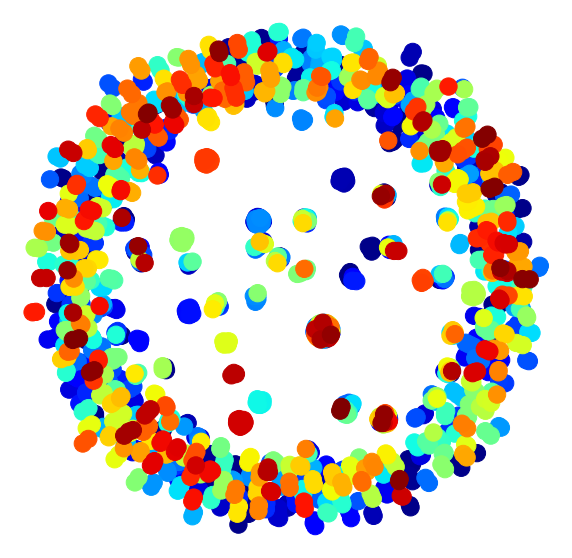

In [193]:
plt.figure(figsize = (10,10))
plt.axis('off')
nx.draw(mynetwork_non, node_color = colors)

This representation does not represent clearely the partitions, because the edges pass through the periphery of the graph.
A better representation would be the planar.

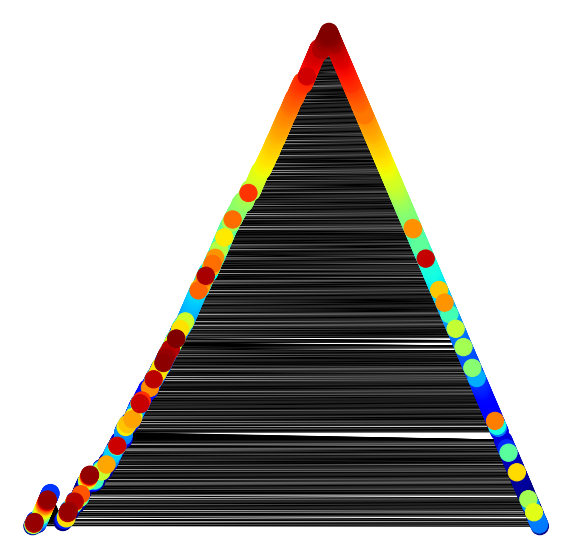

In [194]:
plt.figure(figsize = (10,10))
plt.axis('off')
nx.draw_planar(mynetwork_non, node_color = colors)

Now we can see that the change in color is reasonable

### Core-Periphery

In [94]:
list_comp = [len(com) for com in nx.connected_components(mynetwork_non)]

In [195]:
list_comp.index(max(list_comp))

4

In [198]:
mynetwork_connected = [com for com in nx.connected_components(mynetwork_non)][1]

In [200]:
len(mynetwork_connected)

3

In [202]:
connected_component = mynetwork_non.subgraph(mynetwork_connected)

In [205]:
layers = pd.DataFrame.from_dict(dict(nx.core.onion_layers(connected_component)), orient='index')
layers.reset_index(inplace = True)
layers.columns = ['node', 'layer']

layers.head()

,node,layer
0,Rickie_Special,1
1,amidstbook,1
2,wiccan1978,2
